In [ ]:
!pip install -U tensorflow_datasets

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [10]:
dataset

{'test': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [13]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

In [21]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [17]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

In [18]:
num_train_examples

60000

In [19]:
num_test_examples

10000

In [28]:
train_dataset

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [29]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

In [30]:
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [40]:
for image, label in test_dataset.take(1):
    break
print(type(image), type(label))
print(label)
image = image.numpy().reshape((28, 28))

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(6, shape=(), dtype=int64)


In [41]:
image.shape

(28, 28)

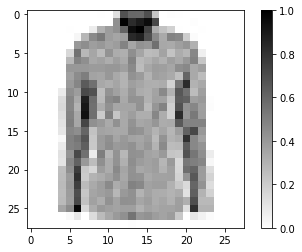

In [42]:
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

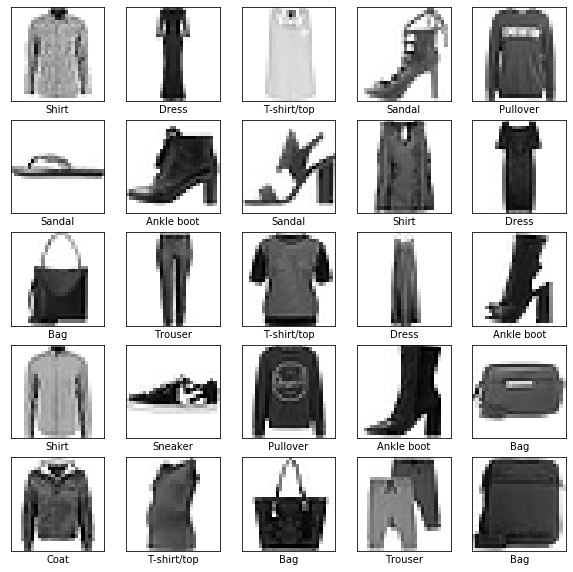

In [43]:
plt.figure(figsize=(10, 10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
num = 0
for image, label in test_dataset:
    num += 1
print(num)

10000


- PyTorchのDataLoaderの機能をDatasetのメソッドで行う

In [57]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

- TensorFlowはPyTorchと違ってchannel-lastなので注意

In [58]:
for image, label in train_dataset:
    print(image.shape, label.shape)
    break

(32, 28, 28, 1) (32,)


In [61]:
# 1epochに何batchあるか？

In [62]:
steps_per_epoch = math.ceil(num_train_examples / BATCH_SIZE)
steps_per_epoch

1875

In [63]:
model.fit(train_dataset, epochs=5, steps_per_epoch=steps_per_epoch)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4951 - accuracy: 0.8249
Epoch 2/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3721 - accuracy: 0.8660
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3358 - accuracy: 0.8761
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3120 - accuracy: 0.8856
Epoch 5/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2949 - accuracy: 0.8903


In [67]:
test_loss, test_accuracy = model.evaluate(
    test_dataset,
    steps=math.ceil(num_test_examples / 32))

313/313 [==============================] - 1s 4ms/step - loss: 0.3587 - accuracy: 0.8710


In [68]:
test_accuracy

0.871

In [71]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [72]:
predictions.shape

(32, 10)

In [73]:
predictions[0]

array([9.8303335e-06, 1.4184334e-08, 2.8656139e-03, 1.0136092e-04,
       2.5956478e-02, 6.7535062e-08, 9.7105700e-01, 4.1840935e-09,
       9.7056754e-06, 5.8417413e-08], dtype=float32)

In [74]:
np.argmax(predictions[0])

6

In [75]:
test_labels[0]

6

In [78]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
  
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

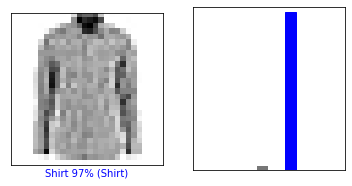

In [79]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

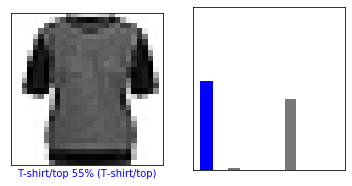

In [80]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

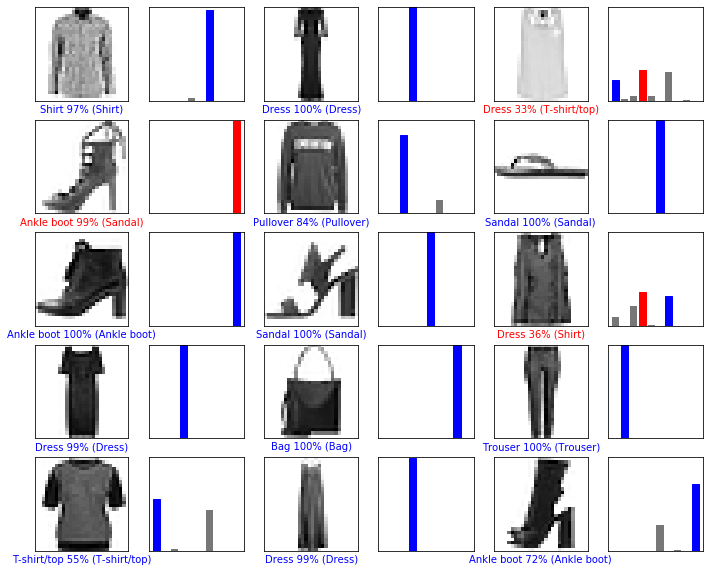

In [81]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

In [86]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [87]:
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [88]:
predictions_single = model.predict(img)
predictions_single

array([[9.83033260e-06, 1.41843595e-08, 2.86561507e-03, 1.01361009e-04,
        2.59565003e-02, 6.75350478e-08, 9.71056879e-01, 4.18408508e-09,
        9.70569272e-06, 5.84174060e-08]], dtype=float32)

In [89]:
np.argmax(predictions_single[0])

6